## read and write edges dataframe

The first try created a binary serialzed object of 800Mb. This was impractical so second try was to use Parquet library. Now the geo dataframe is only 65Mb. 

To open and work on the network you will need

In [1]:
import pandas as pd
import geopandas as gpd
import geoparquet as gpq

## read a geoparquet and get a geodataframe

In [4]:
gdf = gpq.read_geoparquet('/Users/fabien/Dropbox/Urban Data Hackathon/France-city-network/Paris-Directed-network/paris-directed-edges.geoparquet')
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1261666 entries, 561947 to 3793564
Data columns (total 14 columns):
u                 1261666 non-null int64
v                 1261666 non-null int64
osm_id            1261666 non-null object
highway           1261666 non-null object
level             1261666 non-null int64
lanes             1261666 non-null int64
width             1261666 non-null float64
bicycle           1261666 non-null int64
bicycle_safety    1261666 non-null int64
foot              1261666 non-null int64
foot_safety       1261666 non-null int64
max_speed         1261666 non-null int64
motorcar          1261666 non-null int64
geometry          1261666 non-null geometry
dtypes: float64(1), geometry(1), int64(10), object(2)
memory usage: 144.4+ MB


### columns description
* __u__ is the source node
* __v__ is the target node
* __osm_id__ is the original id in openstreetmap. You can see it directly with https://www.openstreetmap.org/way/ + osm_id
* __highway__ is the type of way in openstreetmap. The values are limited. This is used to decide the level. 
* __level__ is a road level. Number between 0 and 8. You should filter on level to Cars only: level >= 3
    * 0 -> unused road, forbidden
    * 1 -> building ways, only for foot
    * 2 -> service (bus), pedetrian streets, bicycle way, etc. NO CAR
    * 3 to 8: road types. 3 is a residential road, up to 8 a highway (A1 for example) 
* __lanes__ is the number of lanes in the street
* __width__ is the total width of the road. It is either declared or estimated with lanes number
* __bicycle__ is access authorized for bicycles, boolean (1 or 0) 
* __bicycle_safety__ is the level of safety for bicycle from 0 (worse) to 3 (dedicated lane). Sidewalks are included as a possible way of level 2 and safety 1.
* __foot__ is access authorized for pedestrians, boolean (1 or 0) 
* __foot_safety__ is the level of safety for pedestrians from 0 (worse) to 3 (dedicated lane). Sidewalks are included as a possible way of level 2 and safety 1.
* __max_speed__ is the declared max speed in openstreetmap. It default to -1 if no information were found.
* __motorcar__ is access authorized for motocar, boolean (1 or 0). Important notice, some level 2 authorize car to park but it should not be used for routing algorithm as there as numerous small graph component disconnected from the main component
* __geometry__ is a shapely linestring with the original path between u and v. Its length is accurate as its bearing. 

### to select only cars

In [5]:
gdf_cars_only = gdf.loc[gdf.level >= 3]

## to select roughly Paris intra-muros

In [6]:
xmin, ymin, xmax, ymax = 1642000,8180000 , 1658000, 8190000
gdf_cars_only_in_paris = gdf_cars_only.cx[xmin:xmax, ymin:ymax]

### to display the data

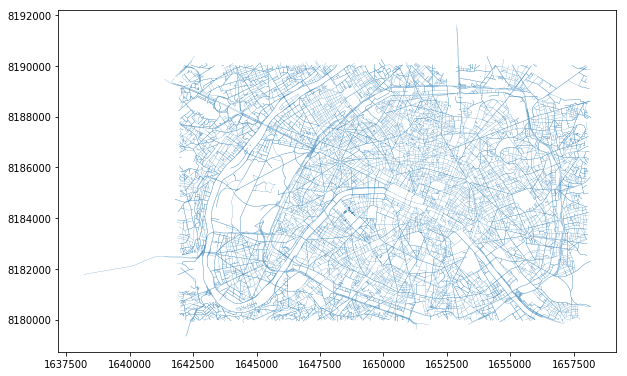

In [9]:
%matplotlib inline
gdf_cars_only_in_paris.plot(linewidth=0.2, figsize=(10, 10))

### to convert the dataframe into a network of your choice

In [10]:
import graph_tool.all as gt
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [11]:
g = gt.Graph(directed=True)
osm_id = g.new_edge_property('string')
level = g.new_edge_property('int')
lanes = g.new_edge_property('int')
max_speed = g.new_edge_property('int')

edgelist = gdf_cars_only_in_paris[
    ['u', 'v', 'osm_id', 'level', 'max_speed']].values

nodes_id = g.add_edge_list(edgelist, hashed=True, eprops=[osm_id, level, max_speed])

In [12]:
dist, ends = gt.pseudo_diameter(g)
print('pseudo diameter: {0}'.format(dist))
print('clustering coefficient: {}'.format(gt.global_clustering(g)))
vs = g.get_vertices()
print('in_degree {}'.format(scipy.stats.describe(g.get_in_degrees(vs))))
print('out_degree {}'.format(scipy.stats.describe(g.get_out_degrees(vs))))
print('is planar: {}'.format(gt.is_planar(g)))

pseudo diameter: 188.0
clustering coefficient: (0.015101434333019984, 0.00041225811417975016)
in_degree DescribeResult(nobs=42175, minmax=(0, 6), mean=1.5108713692946059, variance=0.4905573452169209, skewness=1.1785087552113103, kurtosis=0.9789660827500986)
out_degree DescribeResult(nobs=42175, minmax=(0, 6), mean=1.5108713692946059, variance=0.49842949393414004, skewness=1.2029333563169047, kurtosis=1.1135086389220037)
is planar: False


In [ ]:
A = gt.adjacency(g)

In [ ]:
ew, ev = scipy.linalg.eig(A.todense())

In [ ]:
fig = plt.figure(figsize=(8, 2))
plt.scatter(real(ew), imag(ew), c=sqrt(abs(ew)), linewidths=0, alpha=0.6)
plt.xlabel(r"$\operatorname{Re}(\lambda)$")
plt.ylabel(r"$\operatorname{Im}(\lambda)$")
plt.tight_layout()
plt.show()

### display the graph
We do that on a smaller extract other wise it does not fit well

In [34]:
xmin, ymin, xmax, ymax = 1650000,8184000 , 1652500, 8186000
gdf_zoom_ile_cite = gdf_cars_only.cx[xmin:xmax, ymin:ymax]

g_zoom = gt.Graph(directed=True)
osm_id = g_zoom.new_edge_property('string')
level = g_zoom.new_edge_property('int')
lanes = g_zoom.new_edge_property('int')
max_speed = g_zoom.new_edge_property('int')

edgelist = gdf_zoom_ile_cite[
    ['u', 'v', 'osm_id', 'level', 'max_speed']].values

nodes_id = g_zoom.add_edge_list(edgelist, hashed=True, eprops=[osm_id, level, max_speed])

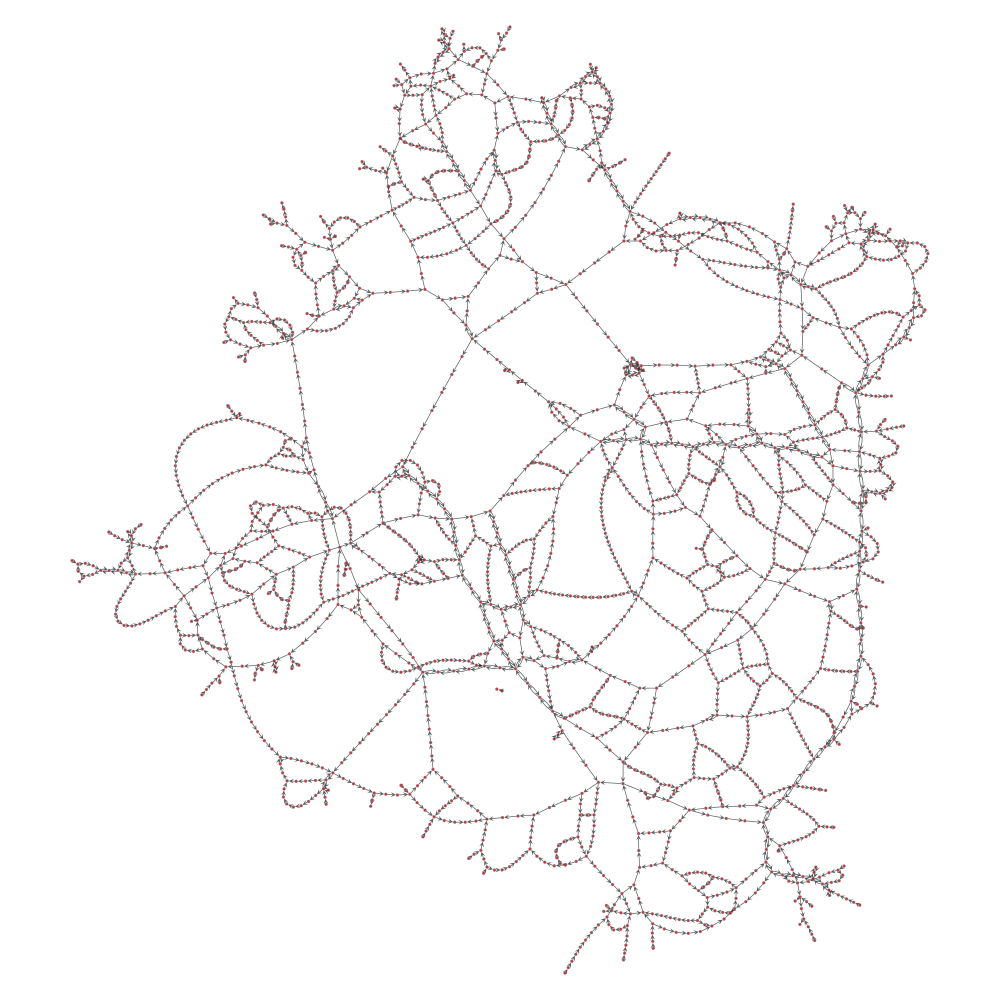

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x193474a10, at 0x1932bd710>

In [48]:
gt.graph_draw(g_zoom,vertex_size=3, edge_pen_width=0.7, edge_marker_size=5, output_size=(1000, 1000), inline=True)

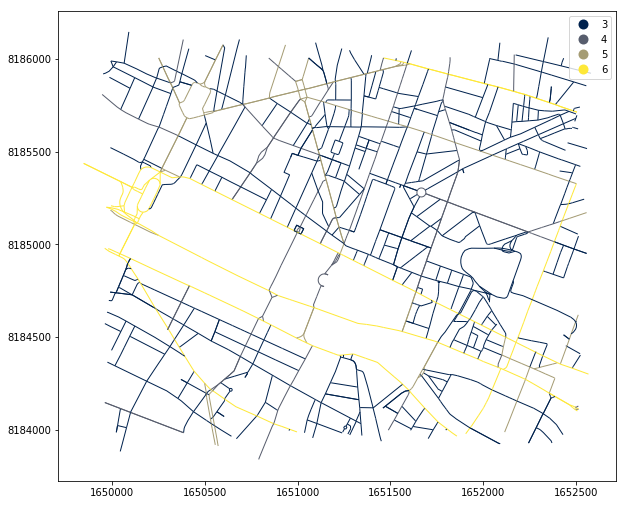

In [44]:
gdf_zoom_ile_cite.plot(linewidth=1, figsize=(10, 10), column='level', legend=True, categorical=True, cmap='cividis')

In [53]:
gdf_zoom_ile_cite.to_geoparquet('/Users/fabien/Dropbox/Urban Data Hackathon/France-city-network/Paris-Directed-network/ile-cite-directed-edges.geoparquet')

In [57]:
gdf_zoom_ile_cite_simple = gpq.read_geoparquet('/Users/fabien/Dropbox/Urban Data Hackathon/France-city-network/Paris-Directed-network/ile-cite-directed-edges-simplified.geoparquet')

In [61]:
g_zoom = gt.Graph(directed=True)
osm_id = g_zoom.new_edge_property('string')
level = g_zoom.new_edge_property('int')
lanes = g_zoom.new_edge_property('int')
max_speed = g_zoom.new_edge_property('int')

edgelist = gdf_zoom_ile_cite_simple[
    ['u', 'v', 'osm_id', 'level', 'max_speed']].values

nodes_id = g_zoom.add_edge_list(edgelist, hashed=True, eprops=[osm_id, level, max_speed])

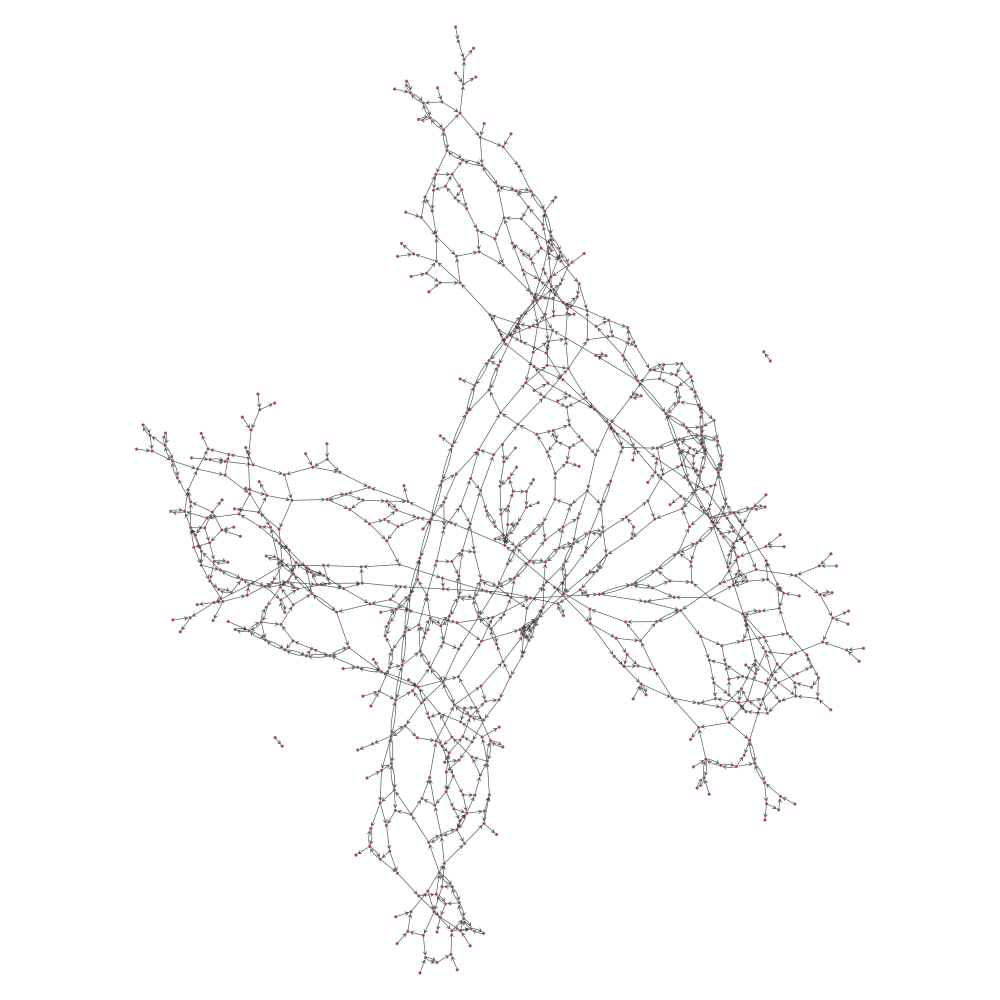

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x194834dd0, at 0x19483d410>

In [63]:
gt.graph_draw(g_zoom,vertex_size=3, edge_pen_width=0.7, edge_marker_size=5, output_size=(1000, 1000), inline=True)

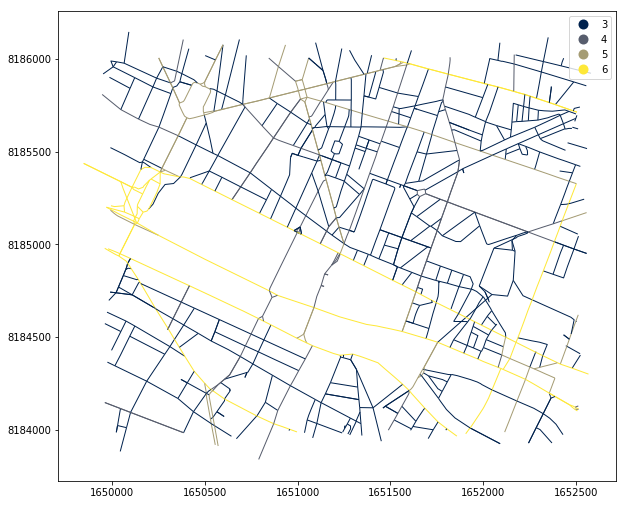

In [64]:
gdf_zoom_ile_cite_simple.plot(linewidth=1, figsize=(10, 10), column='level', legend=True, categorical=True, cmap='cividis')

In [65]:
xmin, ymin, xmax, ymax = 1651750,8184600 , 1652250, 8185100
gdf_zic = gdf_zoom_ile_cite.cx[xmin:xmax, ymin:ymax]
gdf_zics = gdf_zoom_ile_cite_simple.cx[xmin:xmax, ymin:ymax]

In [73]:
g1 = gdf_zic[['u','v','geometry']]
g1['len'] = g1.geometry.length
g2 = gdf_zics[['u','v','geometry']]
g2['len'] = g2.geometry.length

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


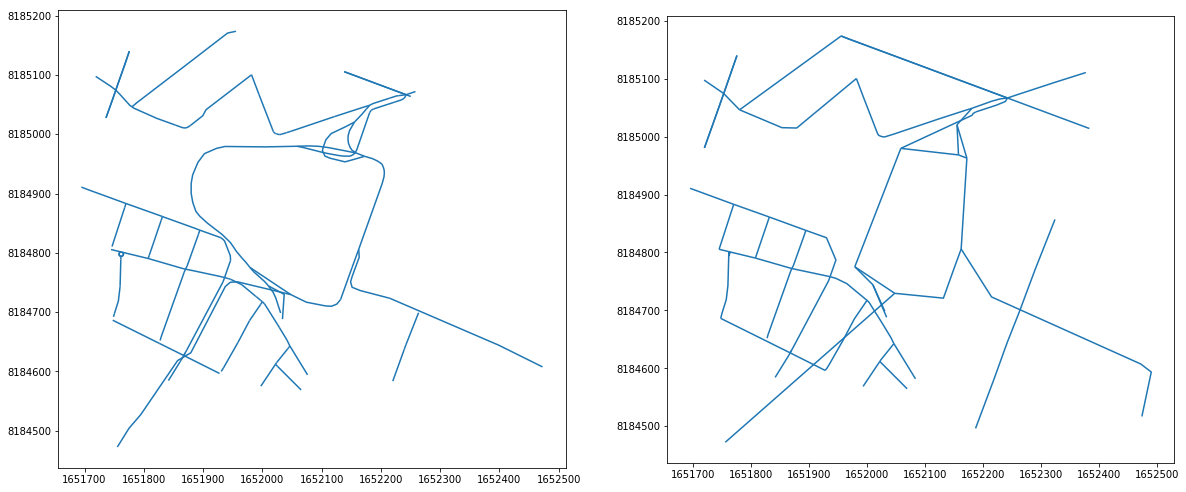

In [85]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(20,10)
g1.plot(ax=ax1)
g2.plot(ax=ax2)
plt.show()